<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

# Construction d'un auto-encodeur avec Keras

<P style="text-align:center"><img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" style="float:center; display: inline" alt="schema"/></P>
*Architecture d'un autoencoder*

## 1. Objectif
#### i. Présentatation générale

L'objectif de ce TP est de construire un auto-encodeur. Un auto-encodeur est un algorithme de compression des données dont les fonctions de compression et décompression reposent sur 3 caratéristiques principales :

* il est **spécifique aux données**, c'est-à-dire qu'il n'est construit que pour un seul type de donnée à la fois, ainsi il ne sera capable de traiter que des données similaires à celles sur lesquelles il s'est entrainé. Cela s'explique de par le fait que les features qu'il aura appris seront propres au type de données qu'il aura traité. 

* il est **à perte**, c'est-à-dire que comme tout compresseur, il fait perdre de leur qualité aux données en sortie par rapport à celles en entrée.
* il est **à apprentissage** : c'est un réseau de neurones donc il a besoin d'exemples de données pour fonctionner.


Pour construire un tel algorithme, il nous faut 3 éléments précis : une **fonction de codage**, une **fonction de décodage** et une **fonction de distance ou fonction de "loss"** (cette dernière permet de calculer la quantité d'information perdue lors de la compression).

Les fonctions de **codage** et de ** décodage** seront des réseaux de neurones différentiable par rapport à la fonction de perte, de manière à ce que les paramètres du codage/décodage puissent être optimisés de sorte que l'on minimise la perte lors de la phase de reconstruction.  

Ce type d'auto-encodeur est très peu utilisé aujourd'hui principalement à cause de sa spécificité aux données.Mais, l'auto-encoding a été longtemps considéré comme un moyen potentiel de résoudre le problème de l'apprentissage non-supervisé ie l'apprentissage sans labels.

L'auto-encoding n'est pas une technique de supervisation d'apprentissage mais plutôt une auto-supervisation (car gènère la valeur souhaitée (target) à partir de l'entrée qui lui a été fournie).

Dans le but de permettre à l'auto-encoder d'apprendre des features intéressantes, on doit lui fournir d'intéressantes target and loss fonctions. 

#### ii. Sum-up

Un **autoencoder** est donc un **réseau de neurones** dont le but est de faire correspondre  ces entrées à ces sorties (sorte de recopie). 

Cela va se faire dans un premier temps par la compression de l'entrée dans une représentation en **espace latent** (latent space est un espace permettant de capturer les features principales des données que l'on traite). Puis dans un second temps on va reconstruire la sortie à partir de la représentation obtenue (représentation dans l'espace latent). 

Comme l'indique le schéma ci-dessus l'autoencoder est composé de deux parties : 

* **Encoder** qui compresse l'entrée dans l'espace latent. 
* **Decoder** qui reconstruit l'entrée à partir de la représentation dans l'espace latent.  

Afin de faire en sorte que l'utilité d'un autoencoder ne soit pas réduite à une simple tâche de recopie on peut limité la taille de la **" compressed representation" ** de sorte qu'elle soit de taille plus petite que celle de l'entrée ainsi cette représentation force l'autoencoder à apprendre que les caractéristiques pertinentes des données. 



## 2. Mise en pratique

### i. Construction Autoencoder

In [64]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

L'objectif ici est de compresser l'image, dont la taille de départ est de 784. Le facteur de compression est de 24,5 : on obtient donc comme taille finale 784/24,5 = 32. Ainsi, la première étape est de donner au réseau de neurône l'image en entrée, en spécifiant sa taille, et d'utiliser la **fonction de codage** sur cette image en entrée. Pour le moment, aucune opération n'est réalisée, on a définie le graphe. On rappelle ici que la fonction **relu (Unité de Rectification Linéaire)** est définie de la façon suivante :

$$relu(x) = max(0,x)$$

et la fonction sigmoid est quant-à-elle définie par :

$$sigmoid(x) = \frac{1}{1+\text{e}^x}$$

à valeurs dans $[0,1]$. Ainsi, on utilise pour décoder la fonction **sigmoid** afin d'obtenir des valeurs de probabilités.

### ii. Construction encoder

In [65]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

**Encoder** est un modèle incluant toutes les couches impliqué dans le calcul de **encoded** à partir de **input_img**.

### iii. Construction decoder

In [66]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1] 
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

**decoder** est un modèle incluant toutes les couches impliqué dans le calcul de **decoded** à partir de **encoded_input**.

**Explication des 2 codes précédents???**


In [67]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### iv. Importation et traitement des données 

In [68]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

**x_train** est à trois dimmensions (on a 60000 images chacune de taile 28x28). Dans la suite on normalise toutes les valeurs et on applatit les valeurs de chaque image de sorte que chaque image soit représenté par un vecteur de taille 784.  

In [69]:
x_train = x_train.astype('float32') / 255. # Pour normaliser toutes les valeurs 
x_test = x_test.astype('float32') / 255.# Pour normaliser toutes les valeurs 
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### v. Phase d'apprentissage de l'autoencoder

In [70]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.3602 - val_loss: 0.2715
Epoch 2/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.2646 - val_loss: 0.2539
Epoch 3/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.2437 - val_loss: 0.2311
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2230 - val_loss: 0.2128
Epoch 5/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.2077 - val_loss: 0.2002
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1964 - val_loss: 0.1901
Epoch 7/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1875 - val_loss: 0.1823
Epoch 8/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1803 - val_loss: 0.1758
Epoch 9/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.1745 - val_loss: 0.1705
Epoch

Dans cette partie nous avons entrainé l'autoencoder à reconstruire des MNIST digits, on va bien que les valeurs loss pour train/test décroissent.

In [71]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

#### vi. Affichage sorties:

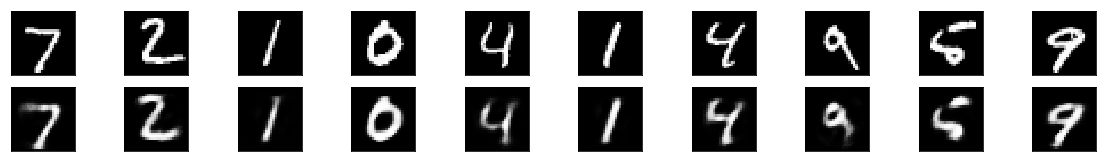

In [75]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Première ligne représentant les entrées, la deuxième ligne quand à elle représente les images reconstruites (on remarque un lègère perte de détails).



#### vii. Affichage sorties intermédiaires :

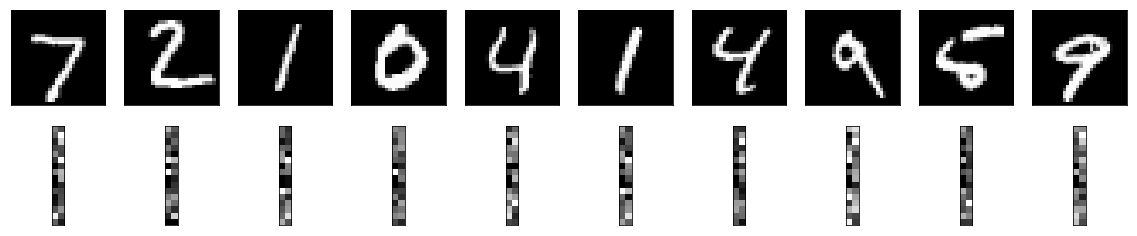

In [76]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(16, 2))
    #plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Autoencoder and sparsity :

In [85]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded2 = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10))(input_img)
# regularizers permet d'éviter l'overfitting en ajoutantla somme des poids lorsqu'on choisit L1 
#ou leur carrés quand on choisit L2.Cost function = Loss (say, binary cross entropy) + Regularization term 
decoded2 = Dense(784, activation='sigmoid')(encoded2)

autoencoder2 = Model(input_img, decoded2)

Regularizers permet d'éviter l'overfitting en ajoutantla somme des poids lorsqu'on choisit L1 ou leur carrés quand on choisit L2.

Cost function = Loss (say, binary cross entropy) + Regularization term 

Cost function = Loss + $\lambda$ $\sum w$, ici $\lambda = 10e-5$.


In [86]:
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy')

In [87]:
autoencoder2.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 39us/step - loss: 267.0058 - val_loss: 0.9539
Epoch 2/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.8711 - val_loss: 0.6818
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.6308 - val_loss: 0.6386
Epoch 4/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.5710 - val_loss: 0.6091
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.5349 - val_loss: 0.5836
Epoch 6/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.5084 - val_loss: 0.5613
Epoch 7/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.4875 - val_loss: 0.5417
Epoch 8/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.4692 - val_loss: 0.5246
Epoch 9/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.4531 - val_loss: 0.5095
Epo

#### vi. Affichage sorties:

In [80]:
# encode and decode some digits
# note that we take them from the *test* set
encodedSparse_imgs = encoder.predict(x_test)
decodedSparse_imgs = decoder.predict(encoded_imgs)

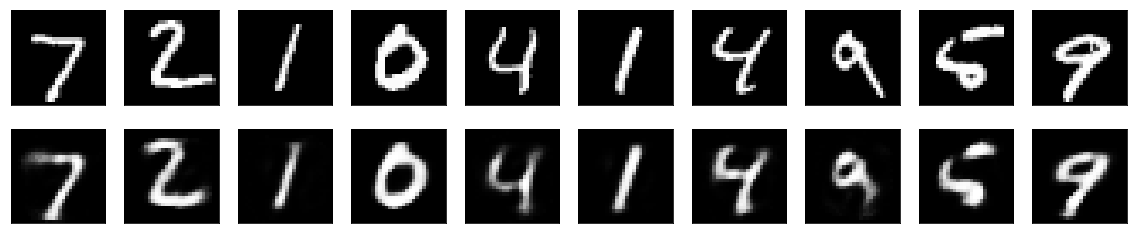

In [81]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decodedSparse_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### vii. Affichage sorties intermédiaires :

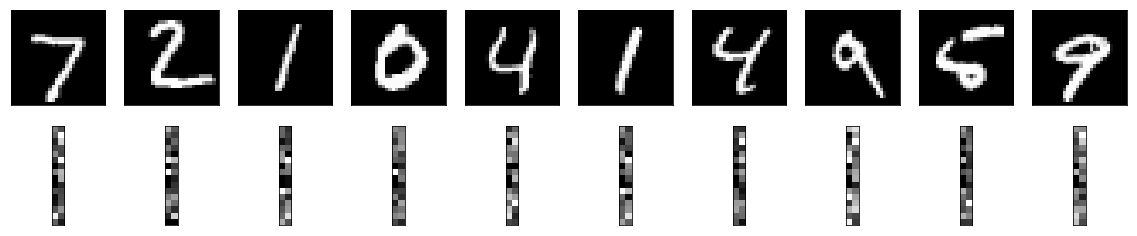

In [82]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encodedSparse_imgs[i].reshape(16, 2))
    #plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### viii. Comparaison sorties intermédiaires Sparse et une couche:

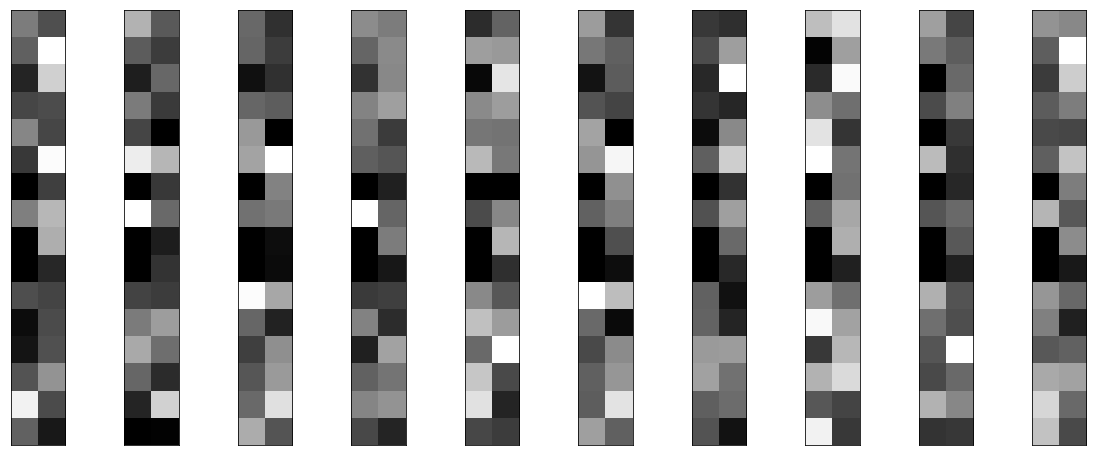

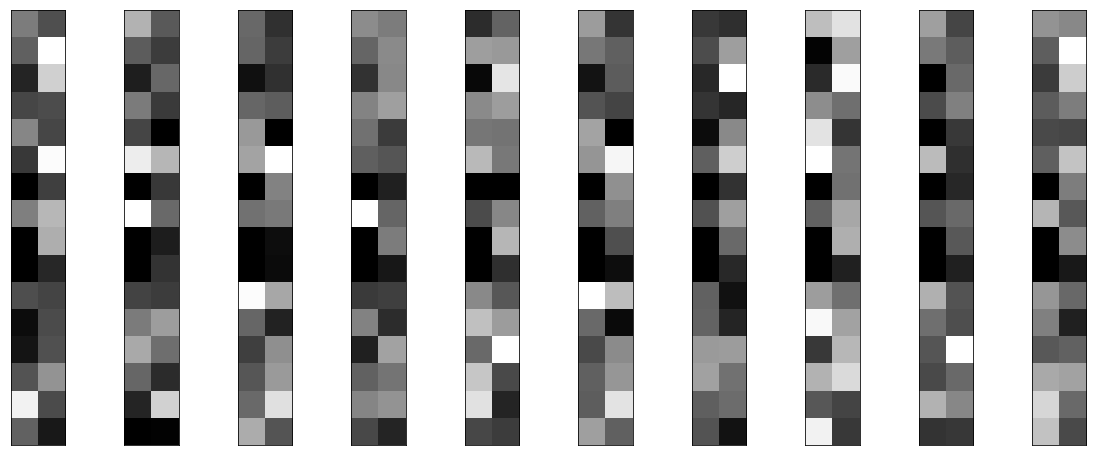

In [83]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(16, 2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encodedSparse_imgs[i].reshape(16, 2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

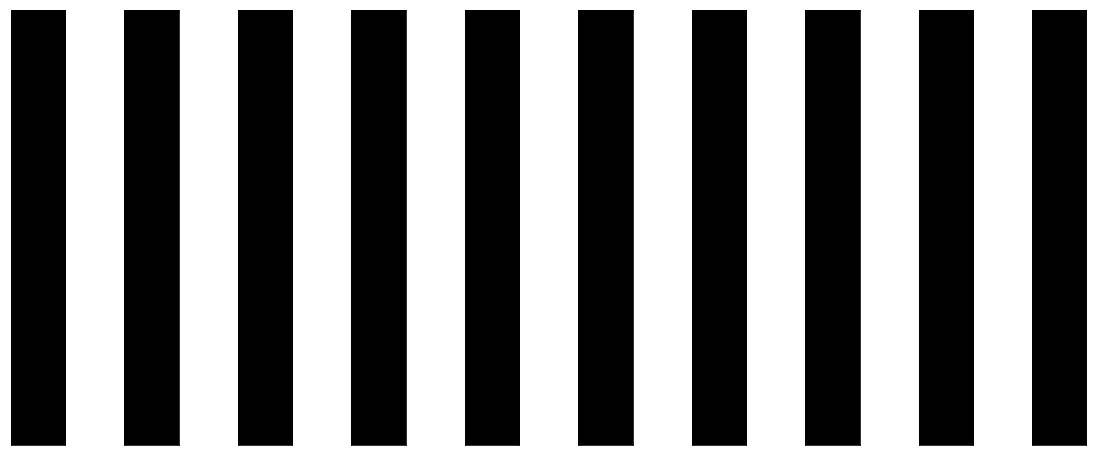

In [84]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow((encodedSparse_imgs[i]-encoded_imgs[i]).reshape(16, 2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Autoencoder et convolutions 


In [44]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [45]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [46]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.2447 - val_loss: 0.1857
Epoch 2/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.1727 - val_loss: 0.1645
Epoch 3/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.1553 - val_loss: 0.1491
Epoch 4/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.1445 - val_loss: 0.1395
Epoch 5/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.1375 - val_loss: 0.1347
Epoch 6/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1330 - val_loss: 0.1301
Epoch 7/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1295 - val_loss: 0.1282
Epoch 8/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.1270 - val_loss: 0.1239
Epoch 9/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1252 - val_loss: 0.1200
Epoch

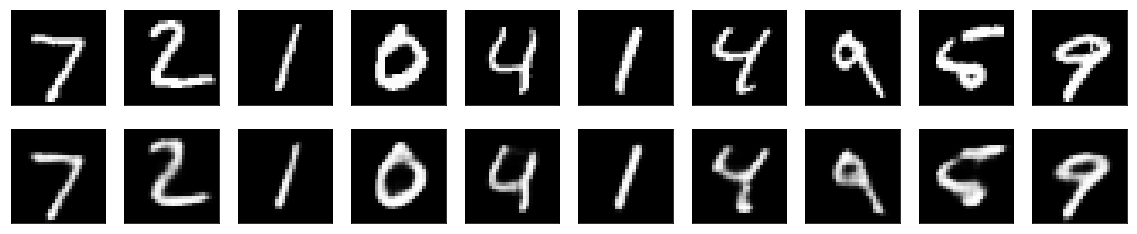

In [50]:

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


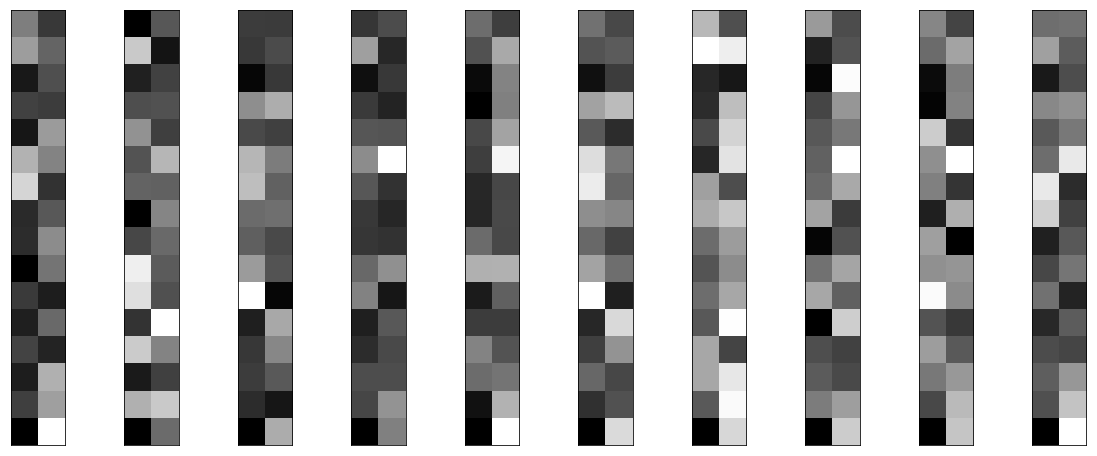

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

In [57]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(16, 2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

n = 10
plt.figure(figsize=(20, 8))
